# Notebook for experimentation with K x P matrix plotting and LD stats

In [4]:
import allel
import zarr
import numcodecs
import numpy as np
import sys
import pandas

### Creating plot of K x P matrices for 3 populations

In [5]:
CHBfilepath = '../../data/ld_mats/chr22_ac5_K200_popCHB.npz'
CEUfilepath = '../../data/ld_mats/chr22_ac5_K200_popCEU.npz'
YRIfilepath = '../../data/ld_mats/chr22_ac5_K200_popYRI.npz'

import numpy as np

loadCHB = np.load(CHBfilepath)
loadCEU = np.load(CEUfilepath)
loadYRI = np.load(YRIfilepath)

CHBmat = loadCHB['ld_mat']
CEUmat = loadCEU['ld_mat']
YRImat = loadYRI['ld_mat']

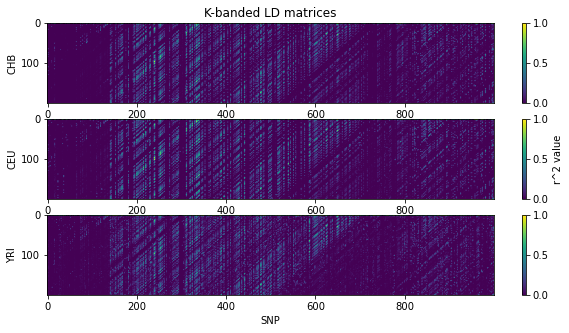

In [7]:
import matplotlib.pyplot as plt

fig,(ax1,ax2,ax3) = plt.subplots(3,figsize=(10,5))

im1 = ax1.imshow(CHBmat[:,3000:4000], aspect='auto')
im2 = ax2.imshow(CEUmat[:,3000:4000], aspect='auto')
im3 = ax3.imshow(YRImat[:,3000:4000], aspect='auto')

ax3.set_xlabel("SNP")
ax1.set_ylabel("CHB")
ax2.set_ylabel("CEU")
ax3.set_ylabel("YRI")

cbar1 = fig.colorbar(im1, ax = ax1)
cbar2 = fig.colorbar(im2, ax = ax2)
cbar3 = fig.colorbar(im3, ax = ax3)

#cbar1.ax.set_ylabel('r^2 value', rotation=90)
cbar2.ax.set_ylabel('r^2 value', rotation=90)
#cbar3.ax.set_ylabel('r^2 value', rotation=90)

ax1.title.set_text("K-banded LD matrices")

#plt.savefig('chr22_LDS_kxp_region1.png',dpi=300)

### Function to return array of LD scores 

In [8]:
from tqdm import tqdm
import numpy as np

def ld_score_v2(LDmat):
    # Creating empty array to be filled with LD scores, length = number of SNPs
    scores = np.zeros(LDmat.shape[1])
    
    # Iterating through each column of K x P matrix
    for i in tqdm(range(LDmat.shape[1])):        
        localmat = LDmat[:,:i+1]
        
        # Taking sum of reverse diagonal of matrix
        flpdiag = np.fliplr(localmat).diagonal()
        diag = np.sum(flpdiag)
        
        # Calculating sum of ith column values
        col = np.sum(LDmat[:,i])
        
        # Adding column and diagonal sums
        scores[i] = col + diag - LDmat[0,i] - LDmat[0,i]
        
    return scores

In [9]:
CHB_LDS_2 = ld_score_v2(CHBmat)
CEU_LDS_2 = ld_score_v2(CEUmat)
YRI_LDS_2 = ld_score_v2(YRImat)

100%|██████████| 384415/384415 [00:04<00:00, 88540.70it/s]


### Producing combined scatter and bar plots of LD scores

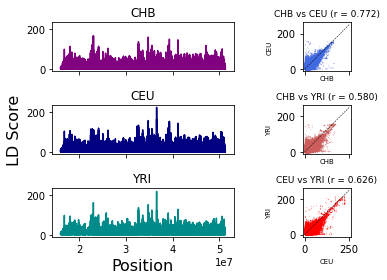

In [12]:
import matplotlib.pyplot as plt

pos = loadCHB['positions']

# Filtering out LD scores of 0 
idx1 = (CHB_LDS_2 > 0) 
idx2 = (CEU_LDS_2 > 0) & (CHB_LDS_2 > 0)
idx3 = (CEU_LDS_2 > 0) 
idx4 = (CHB_LDS_2 > 0) & (YRI_LDS_2 > 0)
idx5 = (YRI_LDS_2 > 0) 
idx6 = (CEU_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='col')

# Plotting y = x
x = np.linspace(0,250,200)

# ax1, 3, 5 are bar plots, 2, 4, 6 are scatter
ax1.plot(pos[idx1],CHB_LDS_2[idx1],color='purple')
ax2.scatter(CHB_LDS_2[idx2], CEU_LDS_2[idx2],s=0.01,color='royalblue')
ax2.plot(x,x,color='black',linewidth=0.5,linestyle='--')
ax3.plot(pos[idx3],CEU_LDS_2[idx3],color='navy')
ax4.scatter(CHB_LDS_2[idx4], YRI_LDS_2[idx4],s=0.01,color='indianred')
ax4.plot(x,x,color='black',linewidth=0.5,linestyle='--')
ax5.plot(pos[idx5],YRI_LDS_2[idx5],color='darkcyan')
ax6.scatter(CEU_LDS_2[idx6], YRI_LDS_2[idx6],s=0.01,color='red')
ax6.plot(x,x,color='black',linewidth=0.5,linestyle='--')

# Setting x and y axis labels
ax2.set_xlabel("CHB", fontsize=7)
ax2.set_ylabel("CEU", fontsize=7)
ax3.set_ylabel('LD Score',fontsize=16)
ax4.set_xlabel('CHB',fontsize=7)
ax4.set_ylabel('YRI',fontsize=7)
ax5.set_xlabel("Position",fontsize=16)
ax6.set_xlabel("CEU",fontsize=7)
ax6.set_ylabel("YRI",fontsize=7)

# Make scatter plots squares rather than rectangles
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_aspect(abs(x1-x0)/abs(y1-y0))
x0,x1 = ax4.get_xlim()
y0,y1 = ax4.get_ylim()
ax4.set_aspect(abs(x1-x0)/abs(y1-y0))
x0,x1 = ax6.get_xlim()
y0,y1 = ax6.get_ylim()
ax6.set_aspect(abs(x1-x0)/abs(y1-y0))

# Setting titles for plots
ax1.title.set_text("CHB")
ax2.title.set_text("CHB vs CEU (r = 0.772)")
ax2.title.set_fontsize(9)
ax3.title.set_text("CEU")
ax4.title.set_text("CHB vs YRI (r = 0.580)")
ax4.title.set_fontsize(9)
ax5.title.set_text("YRI")
ax6.title.set_text("CEU vs YRI (r = 0.626)")
ax6.title.set_fontsize(9)

plt.tight_layout()
#plt.savefig('chr22_LDS_bar_scatter.png',dpi=300)

### Bar plots for entire chr22 to compare CHB/CEU/YRI populations

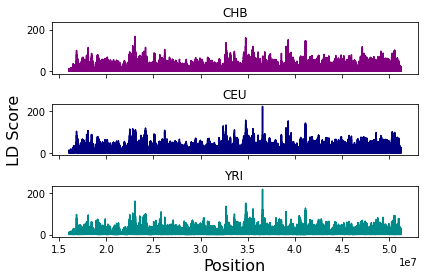

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True,sharey=True)

# Filtering out LD scores of 0
idx1 = (CHB_LDS_2 > 0) 
idx2 = (CEU_LDS_2 > 0) 
idx3 = (YRI_LDS_2 > 0) 

ax1.plot(pos[idx1],CHB_LDS_2[idx1],color='purple')
ax2.plot(pos[idx2],CEU_LDS_2[idx2],color='navy')
ax3.plot(pos[idx3],YRI_LDS_2[idx3],color='darkcyan')

ax2.set_ylabel('LD Score',fontsize=16)
ax3.set_xlabel("Position",fontsize=16)

ax1.title.set_text("CHB")
ax2.title.set_text("CEU")
ax3.title.set_text("YRI")

plt.tight_layout()
#plt.savefig('chr22_LDS_bar.png',dpi=300)

#### Focusing on specific regions of chromosome 22 

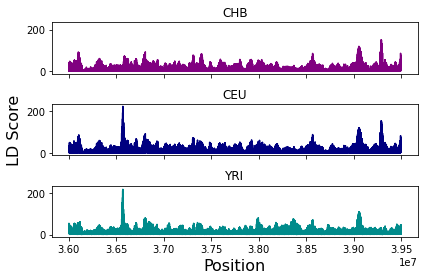

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True,sharey=True)

# Setting lower and upper bounds on positions to be observed
lowerb = 3.6*10**7
upperb = 3.95*10**7

idx4 = (pos[idx1] > lowerb) & (pos[idx1] < upperb)
idx5 = (pos[idx2] > lowerb) & (pos[idx2] < upperb)
idx6 = (pos[idx3] > lowerb) & (pos[idx3] < upperb)

ax1.plot(pos[idx1][idx4],CHB_LDS_2[idx1][idx4],color='purple')
ax2.plot(pos[idx2][idx5],CEU_LDS_2[idx2][idx5],color='navy')
ax3.plot(pos[idx3][idx6],YRI_LDS_2[idx3][idx6],color='darkcyan')

ax2.set_ylabel('LD Score',fontsize=16)
ax3.set_xlabel("Position",fontsize=16)

ax1.title.set_text("CHB")
ax2.title.set_text("CEU")
ax3.title.set_text("YRI")

plt.tight_layout()

#plt.savefig('chr22_LDS_bar_region2.png',dpi=300)

## Individual scatter plots

#### CHB vs CEU

array([[1.        , 0.77152748],
       [0.77152748, 1.        ]])

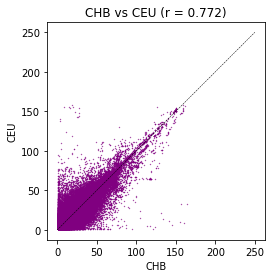

In [13]:
idx = (CEU_LDS_2 > 0) & (CHB_LDS_2 > 0)

fig, ax = plt.subplots()
ax.scatter(CHB_LDS_2[idx],CEU_LDS_2[idx],s=0.1,color='purple')
ax.set_xlabel("CHB")
ax.set_ylabel("CEU")

x = np.linspace(0,250,200)
ax.plot(x, x, color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

ax.title.set_text("CHB vs CEU (r = 0.772)")

#np.corrcoef(CHB_LDS[idx],CEU_LDS[idx])
np.corrcoef(CHB_LDS_2,CEU_LDS_2)

#plt.savefig('CHBvsCEUscatter_chr22.png',dpi=300)

#### CHB vs YRI

array([[1.        , 0.58012865],
       [0.58012865, 1.        ]])

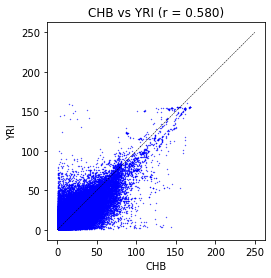

In [14]:
idx = (CHB_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, ax = plt.subplots()
ax.scatter(CHB_LDS_2[idx],YRI_LDS_2[idx], s=0.1, color = 'blue')

ax.set_xlabel("CHB")
ax.set_ylabel("YRI")

ax.plot(x,x,color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

ax.title.set_text("CHB vs YRI (r = 0.580)")

#np.corrcoef(CHB_LDS[idx],YRI_LDS[idx])
np.corrcoef(CHB_LDS_2,YRI_LDS_2)

#plt.savefig('CHBvsYRIscatter_chr22.png',dpi=300)

#### CEU vs YRI

array([[1.        , 0.62616512],
       [0.62616512, 1.        ]])

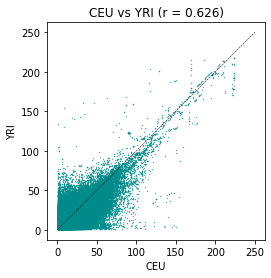

In [13]:
idx = (CEU_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, ax = plt.subplots()
ax.scatter(CEU_LDS_2[idx],YRI_LDS_2[idx], s=0.1, color='darkcyan')

ax.set_xlabel("CEU")
ax.set_ylabel("YRI")

ax.plot(x,x,color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

ax.title.set_text("CEU vs YRI (r = 0.626)")

#np.corrcoef(CEU_LDS[idx],YRI_LDS[idx])
np.corrcoef(CEU_LDS_2,YRI_LDS_2)

#plt.savefig('CEUvsYRIscatter_chr22.png',dpi=300)

## Combined scatter plot for 3 populations

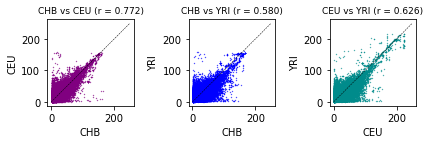

In [15]:
import matplotlib.pyplot as plt

idx1 = (CHB_LDS_2 > 0) & (CEU_LDS_2 > 0)
idx2 = (CHB_LDS_2 > 0) & (YRI_LDS_2 > 0)
idx3 = (CEU_LDS_2 > 0) & (YRI_LDS_2 > 0)

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.scatter(CHB_LDS_2[idx1],CEU_LDS_2[idx1], s=0.1, color='purple')
ax2.scatter(CHB_LDS_2[idx2],YRI_LDS_2[idx2], s=0.1, color='blue')
ax3.scatter(CEU_LDS_2[idx3],YRI_LDS_2[idx3], s=0.1, color='darkcyan')

ax1.set_xlabel("CHB")
ax1.set_ylabel("CEU")
ax2.set_xlabel("CHB")
ax2.set_ylabel("YRI")
ax3.set_xlabel("CEU")
ax3.set_ylabel("YRI")

ax1.plot(x,x,color='black',linewidth=0.5,linestyle='--')
ax2.plot(x,x,color='black',linewidth=0.5,linestyle='--')
ax3.plot(x,x,color='black',linewidth=0.5,linestyle='--')

x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_aspect(abs(x1-x0)/abs(y1-y0))
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_aspect(abs(x1-x0)/abs(y1-y0))
x0,x1 = ax3.get_xlim()
y0,y1 = ax3.get_ylim()
ax3.set_aspect(abs(x1-x0)/abs(y1-y0))

                          
ax1.title.set_text("CHB vs CEU (r = 0.772)")
ax2.title.set_text("CHB vs YRI (r = 0.580)")
ax3.title.set_text("CEU vs YRI (r = 0.626)")

ax1.title.set_fontsize(9)
ax2.title.set_fontsize(9)
ax3.title.set_fontsize(9)

plt.tight_layout()

#np.corrcoef(CEU_LDS[idx],YRI_LDS[idx])
#np.corrcoef(CEU_LDS_2,YRI_LDS_2)

#plt.savefig('combined_scatter_chr22.png',dpi=300)